In [1]:
import os
import re
import string
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Custom functions
import python.custom_functions as cfns

2024-07-31 18:08:43.515613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = os.getcwd()

# Hospital staffing

The dataset we use is provided courtesy of Department of Healthcare Access and Information of California which can be found downloaded from <a href=https://data.chhs.ca.gov/dataset/hospital-staffing-2009-2013> here </a>.

In [3]:
# Import dataset download link from file
with open(path+'/datasets/dataset.url', 'r') as file:
    ds_link = file.read()

# Download dataset
if not os.path.exists(path+'/datasets/'+ds_link.split('/')[-1]):
    tf.keras.utils.get_file(ds_link.split('/')[-1],
                            ds_link, 
                            cache_dir='./',
                            cache_subdir='datasets')

In [4]:
# Load data as a pandas dataframe
df = pd.read_csv(path+'/datasets/'+ds_link.split('/')[-1],
                 delimiter=',',
                 on_bad_lines='warn')
df.head(3)

,Year,Facility Number,Facility Name,Begin Date,End Date,County Name,Type of Control,Hours Type,Productive Hours,Productive Hours per Adjusted Patient Day
0,2009,106010735.0,ALAMEDA HOSPITAL,07/01/2008,06/30/2009,Alameda,District,Management & Supervision,63558,1.17
1,2009,106010735.0,ALAMEDA HOSPITAL,07/01/2008,06/30/2009,Alameda,District,Technician & Specialist,163706,3.02
2,2009,106010735.0,ALAMEDA HOSPITAL,07/01/2008,06/30/2009,Alameda,District,Registered Nurse,180034,3.32


In [5]:
# Rename the "Productive Hours per Adjusted Patient Day" to "PHpAPD"
df = df.rename(columns={"Productive Hours per Adjusted Patient Day" : "PHpAPD"})

# Number of entries
print('Number of entries =', df.shape[0])

# Columns
print('Dataset column names:\n', list(df.columns))
print('\n')

Number of entries = 37604
Dataset column names:
 ['Year', 'Facility Number', 'Facility Name', 'Begin Date', 'End Date', 'County Name', 'Type of Control', 'Hours Type', 'Productive Hours', 'PHpAPD']




## Cleaning and exploration

Our first task is to explore the data to gain a basic understanding of what the columns represent. Armed with this knowledge we can clean the data by filling or dropping rows with missing values before standardizing the data in preparation for quantitative analysis.

In [6]:
# Drop duplicated entries
df = df.drop_duplicates().reset_index(drop=True)

print('Number of unique entries =', df.shape[0])

Number of unique entries = 37604


In [7]:
# Print out the data types
df.dtypes

Year                  int64
Facility Number     float64
Facility Name        object
Begin Date           object
End Date             object
County Name          object
Type of Control      object
Hours Type           object
Productive Hours      int64
PHpAPD              float64
dtype: object

### Facility name and number

Facility Number should be an integer or a string but is registered as float. We need to check if there are any non-integer facility ids in the data. Next, facility name should be strings which we will enforce later.

In [8]:
# Facility Number should be an integer or a string but is registered as float
print('Are there any float valued Facility Number enteries? ', 
      np.any(
          df['Facility Number'][
          (df['Facility Number']-df['Facility Number'].round(0)!=0.0)
          ].notna()))

# Check if 100000000.0 is a valid facility number
print('Is there a facility with facility number 100000000.0? ',
      np.any(cfns.df_mask(df,{'Facility Number':100000000.0}))
     )

# Fill missing values and convert dtype in a new column 'facility_id'
df['facility_id'] = df['Facility Number'].fillna(100000000.0).astype('int64')
print('New column, "facility_id", was created.')

Are there any float valued Facility Number enteries?  False
Is there a facility with facility number 100000000.0?  False
New column, "facility_id", was created.


In [9]:
# Presumably the rows with missing facility number are also missing facility name
print('Do the rows missing facility number and facility name match? ',
      np.all((df['facility_id']==100000000).index==(df['Facility Name'].isna()).index))

# Fill missing values with the string 'na' and convert dtype to string
df['facility_name'] = df['Facility Name'].fillna('na').astype('string')
print('New column, "facility_name", was created.')

Do the rows missing facility number and facility name match?  True
New column, "facility_name", was created.


In [10]:
# Check if facility ids and names are 1 to 1
print('Are there the same number of unique ids and names for facilities? ',
      df.facility_id.nunique() == df.facility_name.nunique())

# Check for facility names with multiple associated ids
print('Are there facility names with multiple associated ids? ',
      np.any(
          df.groupby(
              by=['facility_name']
          )['facility_id'].unique().apply(lambda x: len(x))>1)
     )

# Check for facility ids associated with multiple names
print('Are there facility ids with multiple associated names? ',
      np.any(
          df.groupby(
              by=['facility_id']
          )['facility_name'].unique().apply(lambda x: len(x))>1)
     )
print('\n')

Are there the same number of unique ids and names for facilities?  False
Are there facility names with multiple associated ids?  True
Are there facility ids with multiple associated names?  True




#### Facility name-id disambiguation

We can check that of the two facility names, each with two associated ids, one appears to have changed id in 2013, while the other refers to two facilities in different counties.

##### Facility names with multiple associated ids

In [11]:
# List all the facility names with multiple associated ids
facility_name_multiple_id = list(
    (df.groupby(
        by=['facility_name']
    )['facility_id'].unique().apply(lambda x: len(x))>1)[
    (df.groupby(
        by=['facility_name']
    )['facility_id'].unique().apply(lambda x: len(x))>1)].index)

multiple_associated_ids = []
for name in facility_name_multiple_id:
    multiple_associated_ids.append(
        list(df.facility_id[df.facility_name == name].unique()))

facility_name_multiple_id = {
    name: ids for name, ids in zip(facility_name_multiple_id, multiple_associated_ids)}

print('Facility names with multiple associated ids:')
facility_name_multiple_id

Facility names with multiple associated ids:


{'EDEN MEDICAL CENTER': [106010805, 106014233],
 'ST. MARY MEDICAL CENTER': [106190053, 106361343]}

In [12]:
# Check for apparent reasons for the multiplicities
for name in facility_name_multiple_id.keys():
    print(f"{name}'s id over other columns:\n",
          df[df.facility_name == name].groupby([
              'Year', 
              'County Name', 
              'Type of Control']).facility_id.unique()
         )

EDEN MEDICAL CENTER's id over other columns:
 Year  County Name  Type of Control
2009  Alameda      Non-Profit         [106010805]
2010  Alameda      Non-Profit         [106010805]
2011  Alameda      Non-Profit         [106010805]
2012  Alameda      Non-Profit         [106010805]
2013  Alameda      Non-Profit         [106014233]
Name: facility_id, dtype: object
ST. MARY MEDICAL CENTER's id over other columns:
 Year  County Name     Type of Control
2009  Los Angeles     Non-Profit         [106190053]
      San Bernardino  Non-Profit         [106361343]
2011  Los Angeles     Non-Profit         [106190053]
      San Bernardino  Non-Profit         [106361343]
Name: facility_id, dtype: object


In [13]:
# Facility name with multiple associated ids
n1_id2 = {'name':'EDEN MEDICAL CENTER', 'ids':[106010805,106014233]}

# Find the indices with facility name EDEN MEDICAL CENTER
eden_medical_indices = cfns.df_mask(df,
                                    {'Facility Name':n1_id2['name']},
                                    return_index=True)

# Change all the ids for EDEN MEDICAL CENTER the latest reported id 
df.loc[eden_medical_indices, ['facility_id']] = n1_id2['ids'][1]

In [14]:
# Facilities sharing the same name
c2_n1 = {'name':'ST. MARY MEDICAL CENTER',
         'ids':[106190053,106361343],
         'counties':['Los Angeles','San Bernardino'],
         'suffixes':['LA', 'SB']}

# Append the facility name with county abbreviation
for i in range(2):
    # Select entries with matching name and county
    cs = {'Facility Name':c2_n1['name'], 'County Name':c2_n1['counties'][i]}
    # Append name with county abbreviation in new_name string
    new_name = c2_n1['name'].join([' ',c2_n1['suffixes'][i]])
    # Change the name in df
    df.loc[cfns.df_mask(df, cs, return_index=True), ['facility_name']] = new_name

In [15]:
# Check the results
# List all the facility names with multiple associated ids
facility_name_multiple_id = list(
    (df.groupby(
        by=['facility_name']
    )['facility_id'].unique().apply(lambda x: len(x))>1)[
    (df.groupby(
        by=['facility_name']
    )['facility_id'].unique().apply(lambda x: len(x))>1)].index)

multiple_associated_ids = []
for name in facility_name_multiple_id:
    multiple_associated_ids.append(
        list(df.facility_id[df.facility_name == name].unique()))

facility_name_multiple_id = {
    name: ids for name, ids in zip(facility_name_multiple_id, multiple_associated_ids)}

print('Remaining facility names with multiple associated ids:',
      facility_name_multiple_id)

print('\n')

Remaining facility names with multiple associated ids: {}




##### Facility ids with multiple associated names

In [16]:
# List all the facility ids with multiple associated names
facility_id_multiple_name = list(
    (df.groupby(
        by=['facility_id'])['facility_name'].unique().apply(lambda x: len(x))>1)[(
        df.groupby(
            by=['facility_id'])['facility_name'].unique().apply(lambda x: len(x))>1
    )].index)

multiple_associated_names = []
for id in facility_id_multiple_name:
    multiple_associated_names.append(
        list(df.facility_name[df.facility_id == id].unique()))

# Strip facility names to check for non-trivial differences
strip_chars = '['+re.escape(string.punctuation+' -')+']'
print('ids with multiple associated names:')
for id, names in zip(facility_id_multiple_name, multiple_associated_names):
    if pd.Series(names).str.replace(strip_chars,'', regex=True).nunique() > 1:
        print(id, names)

ids with multiple associated names:
106100797 ['SIERRA KINGS DISTRICT HOSPITAL', 'ADVENTIST MEDICAL CENTER - REEDLEY']
106190053 [' ST. MARY MEDICAL CENTERLA', 'ST. MARY MEDICAL CENTER - LOS ANGELES', 'ST. MARY MEDICAL CENTER - LONG BEACH']
106190517 ['TARZANA MEDICAL CENTER', 'PROVIDENCE TARZANA MEDICAL CENTER']
106361343 [' ST. MARY MEDICAL CENTERSB', 'ST. MARY MEDICAL CENTER - APPLE VALLEY']
106370782 ['UNIVERSITY OF CALIF - SAN DIEGO MEDICAL CENTER', 'UNIVERSITY OF CALIFORNIA SAN DIEGO MEDICAL CENTER']


In [17]:
# There are only 3 facilities that need a different id:
facility_id_multiple_name = [
    'ADVENTIST MEDICAL CENTER - REEDLEY',
    'ST. MARY MEDICAL CENTER - LONG BEACH',
    'ST. MARY MEDICAL CENTER - APPLE VALLEY'
]

for i in range(len(facility_id_multiple_name)):
    # Select entries with matching facility name
    cs = {'Facility Name': facility_id_multiple_name[i]}
    # Generate a new id to associate with facility
    new_id = df.facility_id.max()+1
    # Change the id of facility entries to new_id
    df.loc[cfns.df_mask(df, cs, return_index=True), ['facility_id']] = new_id
    # Print update message
    print(f"{facility_id_multiple_name[i]} facility now has id = {new_id}")

ADVENTIST MEDICAL CENTER - REEDLEY facility now has id = 106580997
ST. MARY MEDICAL CENTER - LONG BEACH facility now has id = 106580998
ST. MARY MEDICAL CENTER - APPLE VALLEY facility now has id = 106580999


#### Facilities table

Having resolved the ambiguities in pairing names and ids of all the facilities in the dataset, we only need facility ids moving forward. We create a new table to store facility names and drop the name columns ("Facility Name" and "facility_name") as well as the duplicate "Facility Number" column.

In [18]:
# Create a new dataframe with index=facility_id and columns facility_name and county.
facilities = df.copy().groupby(by=['facility_id','County Name'])['facility_name'].unique()

# Rename columns
facilities = facilities.reset_index().rename(
    columns={'facility_name':'names', 'County Name':'county'})

# Create the facility_name column with only the first name in the list of 
# names for each facility.
facilities['facility_name'] = facilities.names.map(lambda x: x[0]).astype("string")

# Drop the names column with multiple spelling of the name for each facility.
facilities = facilities.drop(columns=['names']).set_index('facility_id')

# Reorder the columns
facilities = facilities[['facility_name', 'county']]

print('Created the facilities dataframe with {} unique entries.'.format(
    facilities.shape[0]))
facilities.head(5)

Created the facilities dataframe with 467 unique entries.


,facility_name,county
facility_id,,
100000000,na,Statewide
106010735,ALAMEDA HOSPITAL,Alameda
106010739,ALTA BATES SUMMIT MED CTR-ALTA BATES CAMPUS,Alameda
106010776,CHILDRENS HOSPITAL & RESEARCH CENTER AT OAKLAND,Alameda
106010782,THUNDER ROAD CHEMICAL DEPENDENCY RECOVERY HOSP...,Alameda


In [19]:
# Drop the facility name/number keeping only facility_id.
df = df.drop(columns=['Facility Name', 'Facility Number', 'facility_name'])
df.head(3)

,Year,Begin Date,End Date,County Name,Type of Control,Hours Type,Productive Hours,PHpAPD,facility_id
0,2009,07/01/2008,06/30/2009,Alameda,District,Management & Supervision,63558,1.17,106010735
1,2009,07/01/2008,06/30/2009,Alameda,District,Technician & Specialist,163706,3.02,106010735
2,2009,07/01/2008,06/30/2009,Alameda,District,Registered Nurse,180034,3.32,106010735


### Date columns

It is quite convenient to express dates with the datetime data type which in particular enables us to easily evaluate duration as the difference of two datetime type objects.

In [20]:
print('Column data types:\n', df.dtypes)

Column data types:
 Year                  int64
Begin Date           object
End Date             object
County Name          object
Type of Control      object
Hours Type           object
Productive Hours      int64
PHpAPD              float64
facility_id           int64
dtype: object


In [21]:
# Convert dates to pandas datetime data type
df['Begin Date'] = pd.to_datetime(df['Begin Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

# Make sure End Date is always after Begin Date
print('Is End Date after Begin Date for all valid (non-null) rows?',
     np.all(df['Begin Date'].dropna() < df['End Date'].dropna()))

# Create a new column and store the 'duration' of each entry
# duration = End Date - Begin Date  (duration>0)
df['duration'] = df['End Date'] - df['Begin Date']
print('New column, "duration", was created.\n')

Is End Date after Begin Date for all valid (non-null) rows? True
New column, "duration", was created.



### Missing values

Let us check for any missing values in the dataset, specially for the dates and productive hours columns. Note that we have already filled the missing facility_id values with 0.

In [22]:
# Count the missing values
df.isna().sum()

Year                  0
Begin Date           85
End Date             85
County Name           0
Type of Control      85
Hours Type            0
Productive Hours      0
PHpAPD              187
facility_id           0
duration             85
dtype: int64

#### Missing dates

It is easy to check that "County Name" takes the value "Statewide" in 85 rows suggesting that these rows aggregate information from multiple facilities over different periods. Consequently, these rows are missing begin and end dates as well as facility information and type of control. We can try to fill in some missing information using appropriate aggregate functions of the other rows or just drop them altogether. For now, we will store them separately and turn our attention to the missing productive hours per adjusted patient day (PHpAPD).

In [23]:
# Store the statewide entries separately
df_statewide = df.copy()[cfns.df_mask(df,{'County Name':'Statewide'})]
# Drop statewide entries from df and reset index
df = df.drop(index = df_statewide.index).reset_index(drop=True)
# Reset df_statewide index
df_statewide = df_statewide.reset_index(drop=True)

df_statewide.head(3)

,Year,Begin Date,End Date,County Name,Type of Control,Hours Type,Productive Hours,PHpAPD,facility_id,duration
0,2010,NaT,NaT,Statewide,NaN,Environmental & Food Services,48811411,1.62,100000000,NaT
1,2010,NaT,NaT,Statewide,NaN,Other,79203513,2.62,100000000,NaT
2,2010,NaT,NaT,Statewide,NaN,Contracted Registry Nursing,11529563,0.38,100000000,NaT


In [24]:
# Now we are only left with missing values in the
# Productive Hours per Adjusted Patient Day column.
df.isna().sum()

Year                  0
Begin Date            0
End Date              0
County Name           0
Type of Control       0
Hours Type            0
Productive Hours      0
PHpAPD              187
facility_id           0
duration              0
dtype: int64

In [25]:
# Of the 187 missing values, most can be set to 0 since these entries have
# Productive Hours = 0.
zero_PHpAPD_indices = df[(df['Productive Hours'] == 0) & (df['PHpAPD'].isna())].index

# Fill these missing value with 0
df.loc[zero_PHpAPD_indices, ['PHpAPD']] = 0

In [26]:
# Collect the indices of the remaining rows with missing values
missing_PHpAPD_indices = df[df['PHpAPD'].isna()].index

# Observe that they share almost every column
print('Number of unique values in each column for rows with missing values:\n')
print(df.iloc[missing_PHpAPD_indices].nunique())

# List all the columns
cols = list(df.columns)
# Keep only the columns with a single unique value across the rows with missing values.
del cols[5:8]

print('\n')
print('The unique values shared by all rows with missing values:\n')
print(df.loc[missing_PHpAPD_indices,cols].groupby(cols[1:]).Year.unique())

Number of unique values in each column for rows with missing values:

Year                 1
Begin Date           1
End Date             1
County Name          1
Type of Control      1
Hours Type          15
Productive Hours    15
PHpAPD               0
facility_id          1
duration             1
dtype: int64


The unique values shared by all rows with missing values:

Begin Date  End Date    County Name  Type of Control  facility_id  duration
2011-07-01  2012-06-30  Los Angeles  Non-Profit       106191216    365 days    [2012]
Name: Year, dtype: object


In [27]:
# Check if the indices are selected correctly
np.all(df.loc[missing_PHpAPD_indices, ['PHpAPD']].isna())

True

#### Inferring missing values

As you can see, the rows with missing values are all entries from the same facility from a single year. Since we are only missing the values from the Productive Hours per Adjusted Patient Day column, we should be able to infer the value from the Productive Hours by making informed assumptions about the volume of patients.

In [28]:
# Create a new column, DPH, to store Daily Productive Hours = (Productive Hours)/(duration)
df['DPH'] = df['Productive Hours'] / df.duration.dt.days
print('New column, "DPH", was created.')

New column, "DPH", was created.


In [29]:
# Recall the cols list defined above
print('Columns for which the rows with missing values all share the same value:\n',
      cols)

Columns for which the rows with missing values all share the same value:
 ['Year', 'Begin Date', 'End Date', 'County Name', 'Type of Control', 'facility_id', 'duration']


In [30]:
# select the facility id and type of control for which data is missing
toc, fid = df.loc[missing_PHpAPD_indices,cols].groupby(
    cols[1:]).Year.unique().reset_index()[['Type of Control', 'facility_id']].to_numpy()[0]

# Create mask to select COMPLETE entries with toc and fid.
mask = cfns.df_mask(df, {'facility_id':fid, 'Type of Control':toc})
mask = mask & df['PHpAPD'].notna()

# Prepare data for the plot
Htypes = df['Hours Type'].unique()
Xs = {t:df[mask & (df['Hours Type'] == t)].PHpAPD for t in Htypes}
Ys = {t:df[mask & (df['Hours Type'] == t)].DPH for t in Htypes}

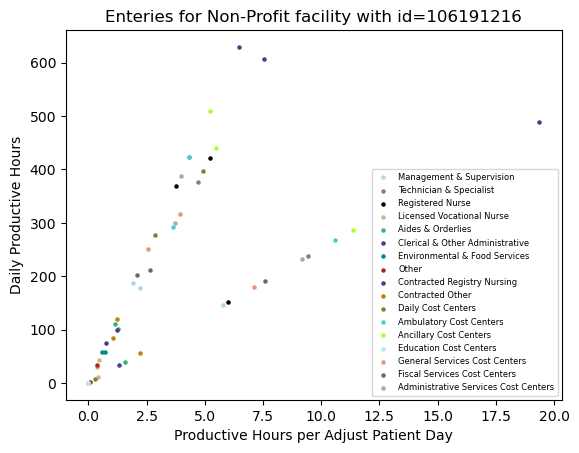

In [31]:
# Generate a list of colors for the plot
colors = cfns.random_colors(Htypes)

# Plot the data for different Hours Type
fig = plt.figure()
for type in Htypes:
    plt.scatter(Xs[type], Ys[type], 5, colors[type], label=type)

plt.title('Enteries for {} facility with id={}'.format(
    toc, fid))
plt.xlabel('Productive Hours per Adjust Patient Day')
plt.ylabel('Daily Productive Hours')
plt.legend(loc="lower right", fontsize=6)
          
plt.show()

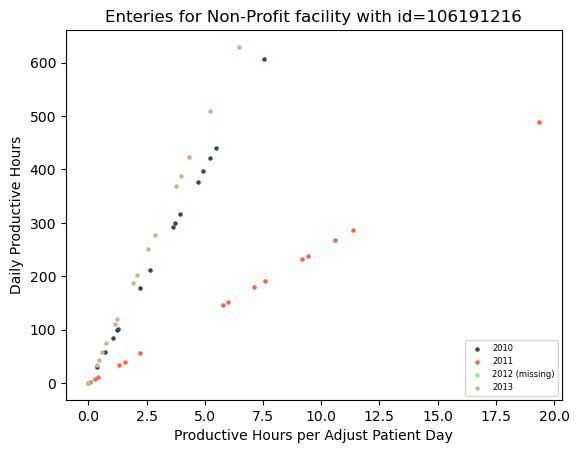

In [32]:
# The plot clearly shows 3 linear trends which should correspond
# to the 3 years for which we have COMPLETE data. 
# (Recall that all the missing values are from 2012.)
years = np.arange(2010,2014, 1)
X = {y:df[mask & (df['Year'] == y)].PHpAPD for y in years}
Y = {y:df[mask & (df['Year'] == y)].DPH for y in years}

# Generate a list of colors for the plot
colors = cfns.random_colors(years, 1)

# Plot the data for each year
fig = plt.figure()
for y in years:
    plt.scatter(X[y], Y[y], 5, colors[y], label=f'{y}'.replace(
        '2012', '2012 (missing)'))

plt.title('Enteries for {} facility with id={}'.format(
    toc, fid))
plt.xlabel('Productive Hours per Adjust Patient Day')
plt.ylabel('Daily Productive Hours')
plt.legend(loc="lower right", fontsize=6)

plt.show()

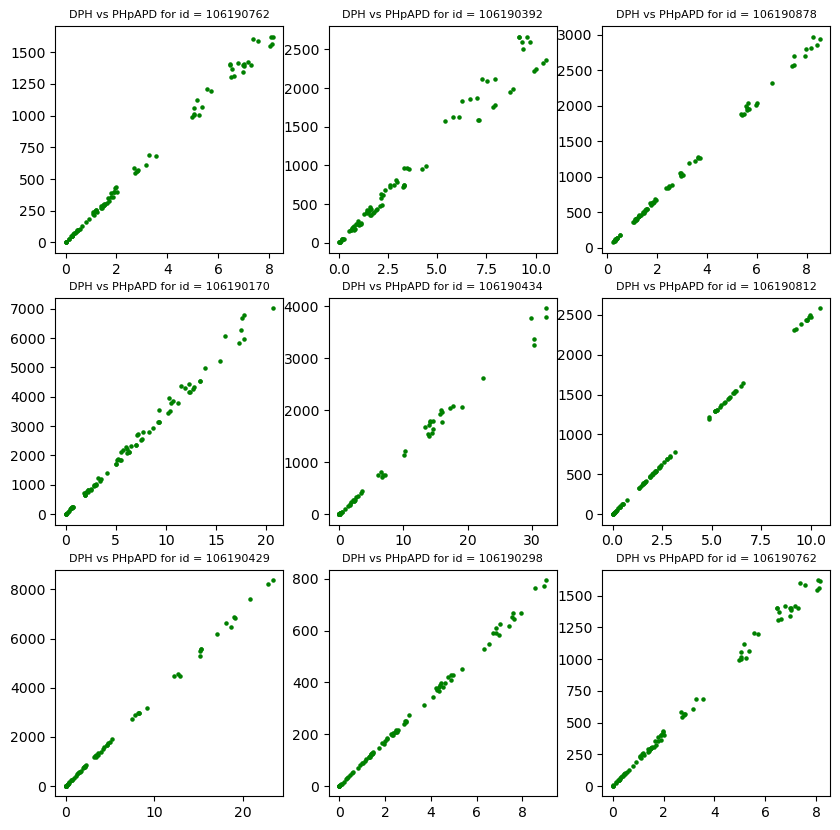

In [33]:
# List facility ids with similar features 
#(type of control = Non Profit, County Name = )
np_la_mask = cfns.df_mask(df,{'Type of Control':'Non-Profit', 'County Name':'Los Angeles'})

np_la_fids = df[np_la_mask].facility_id.unique()

# Select a few of the facilities at random
k = 9
np.random.seed(2)
fids = np.random.choice(np_la_fids, k)

# Create masks to select corresponding entries.
masks=[cfns.df_mask(df,{'Type of Control':toc,'facility_id':fids[i]}) for i in range(k)]

# Select the data to plot from these entries
Xs=[df[masks[i]].PHpAPD for i in range(k)]
Ys=[df[masks[i]].DPH for i in range(k)]

# Plot the data for all hour types and available years
fig, axs = plt.subplots(3, 3)
fig.set_figheight(10)
fig.set_figwidth(10)
for i in range(k):
    axs[i//3, i%3].scatter(Xs[i], Ys[i], 5, 'green', label=f'{fids[i]}')
    axs[i//3, i%3].set_title('DPH vs PHpAPD for id = {}'.format(fids[i]), size=8)
plt.show()

##### Linear regression

The plots above of "Productive Hours per Adjusted Patient Day" vs "Daily Productive Hours" strongly suggest a linear relation between the two quantities which is different for each facility but constant over the years. We will test this assumption below to confirm its validity.

This renders the plot for facility with id=106191216 an anomaly in the amount of variation in the slope of the plots for each year. Nonetheless, in lieu of extra information that could explain the variance, the conservative approach to inferring the missing data is to use the average of the slopes which is done by the model below.

In [34]:
# Testing the linear correlation of DPH and PHpAPD: 
# DPH[i] = w[i]*PHpAPD[i] for all i in facility_ids.
cols = ['facility_id','DPH','PHpAPD']

# Estimate the weights, w[i], via w[i] = mean(DPH)[i]/mean(PHpAPD)[i]
df_copy = df.copy()[cols].dropna()
LR_weights = df_copy.groupby(['facility_id']).mean().apply(
    lambda x: x[0]/(x[1]+0.000001), axis=1).rename('LR_weights').reset_index()

# Compute the predictions of linear model: 
# DPH_predictions[i] = w[i] * PHpAPD[i]
linear_predictions = LR_weights.merge(
    df_copy[cols], 'right', on=['facility_id'])[['LR_weights','PHpAPD']].apply(
    lambda x: x[0]*x[1], axis=1).to_numpy()

# Evaluate R-squared score for the model
r2_linear = cfns.r2_score(df_copy.DPH.to_numpy(), linear_predictions)

# Print results
print('Assuming a linear correlation between DPH and PHpAPD yields an R-squared score of:\n',
      np.round(r2_linear,4))

Assuming a linear correlation between DPH and PHpAPD yields an R-squared score of:
 0.9939


In [35]:
# Collect all the complete data for the facility 106191216 (remove the outliers)
mask = (df['facility_id']==fid) & (df['Type of Control']==toc) & (df['PHpAPD'].notna())
threshold = np.quantile(df[mask].PHpAPD.to_numpy(),0.9)
mask = mask & (df['PHpAPD'] < threshold)
X = df[mask].PHpAPD.to_numpy()
Y = df[mask].DPH.to_numpy()

# Use the estimated Linear Regression weight from above
weight_106191216 = LR_weights[LR_weights.facility_id == fid].LR_weights.to_numpy()[0]
y = weight_106191216*X

# Evaluate R-squared score for the fitted line
r_squared_106191216 = cfns.r2_score(Y,y)

# Print the results
print('The linear model for facility id=106191216 yields the R-squared score of:\n',
      np.round(r_squared_106191216,4))

The linear model for facility id=106191216 yields the R-squared score of:
 0.7059


##### Infer the missing values using the linear model

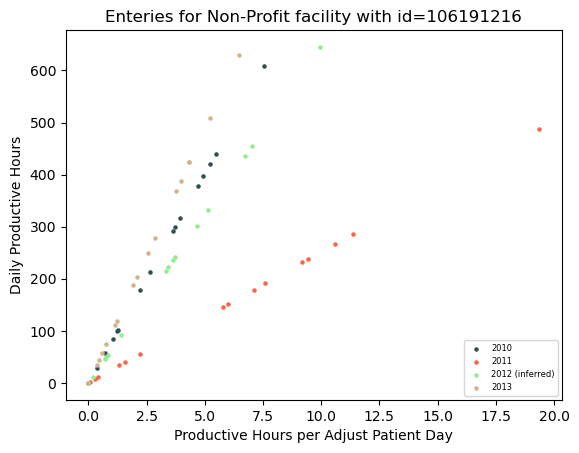

In [36]:
# Infer the values using model.predict
inferred_missing_values = df.loc[missing_PHpAPD_indices].DPH.to_numpy()/weight_106191216

# Fill in the missing values
df.loc[missing_PHpAPD_indices, ['PHpAPD']] = inferred_missing_values

# Plot
mask = cfns.df_mask(df, {'facility_id':fid, 'Type of Control':toc})
years = np.arange(2010,2014, 1)
X = {y:df[mask & (df['Year'] == y)].PHpAPD for y in years}
Y = {y:df[mask & (df['Year'] == y)].DPH for y in years}
colors = cfns.random_colors(years, 1)

# Plot the data for each year
fig = plt.figure()
for y in years:
    plt.scatter(X[y], Y[y], 5, colors[y], label=f'{y}'.replace(
        '2012', '2012 (inferred)'))

plt.title('Enteries for {} facility with id={}'.format(
    toc, fid))
plt.xlabel('Productive Hours per Adjust Patient Day')
plt.ylabel('Daily Productive Hours')
plt.legend(loc="lower right", fontsize=6)

plt.show()

In [37]:
# And that should be all the missing values
df.isna().sum()

Year                0
Begin Date          0
End Date            0
County Name         0
Type of Control     0
Hours Type          0
Productive Hours    0
PHpAPD              0
facility_id         0
duration            0
DPH                 0
dtype: int64

### Time window

Before we go any further, we need check the resolution of the data. Since we will be treating the data as a time series, we need to find the smallest time window for which we can perform valid quantitative analysis.

We can check (see plot below) that the vast majority of the entries have duration~1 year. Simply put, we do not have the resolution to analyze the data with smaller time windows and thus can only choose the window size time_step = 1 year.

In [38]:
# Count the number of entries with duration of less than 190 days
print('The number of entries with duration < 190 days / total number of entries =',
      '{} / {}'.format(np.sum(df.duration.dt.days < 100), df.shape[0]))

The number of entries with duration < 190 days / total number of entries = 119 / 37519


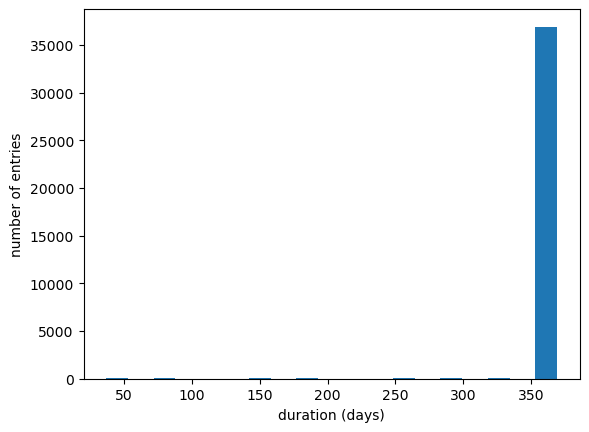

In [39]:
# Plot the distribution of values for the duration column
x, y = cfns.bucketize(df.duration.dt.days.to_numpy(), 10)

plt.bar(np.round(x), y, width=16)
plt.xlabel('duration (days)')
plt.ylabel('number of entries')

plt.show()

Trends/seasonality:

With time_step=1 year, seasonality can be ruled out altogether. That leaves us with possible trends, a cursory look at the plots of "Productive Hours per Adjusted Patient Day" and "Daily Productive Hours" reveals no major or obvious trends. We can leave a detailed analysis to our machine learning models.

### Time series availability

With time window of 1 year, we need to check the length of the time series available for each facility, type of control and hour type.

In [40]:
# Create a copy of df and check the number length of the sequence available
# for each unique set of values in group_cols:
group_cols = ['facility_id','Type of Control','Hours Type']
ts_df = df.copy().groupby(group_cols).Year.count().rename('seq_len')

# Print a report on the distribution of unique values
ts_df.reset_index().groupby(['seq_len']).nunique()

,facility_id,Type of Control,Hours Type
seq_len,,,
1,21,3,17
2,20,4,17
3,17,4,17
4,25,4,17
5,399,5,17


In [41]:
# Merge df and ts_df to add the new column, seq_len, to df.
df = df.merge(ts_df, 'left', on=group_cols)

# Keep a copy of the original dataframe
df_original = df.copy()

# Drop all entries with less than 3 consecutive reports
df = df[df.seq_len>2]

## Standardization and vectorization

Before we go further in our analysis of the date, we should standardize the quantitative columns, 'Productive Hours' and 'Productive Hours per Adjusted Patient Day' and vectorize the categorical columns.

### Categorical columns

Most of the columns have categorical values. We will first treat the columns with relatively few categories, namely, 'Year', 'County Name', 'Type of Control' and 'Hours Type'. The latter 3 take string values.

In [42]:
# List the categorical columns
categorical_cols = ['Year',
                    'facility_id',
                    'County Name',
                    'Type of Control',
                    'Hours Type']

# Change dtype for categorical_cols[2:] to string
for col in categorical_cols[2:]:
    df[col] = df[col].astype("string")

# Print out the data types
df.dtypes

Year                          int64
Begin Date           datetime64[ns]
End Date             datetime64[ns]
County Name                  string
Type of Control              string
Hours Type                   string
Productive Hours              int64
PHpAPD                      float64
facility_id                   int64
duration            timedelta64[ns]
DPH                         float64
seq_len                       int64
dtype: object

In [43]:
# Define new names for the vectorized columns
vectorized_cols = ['y', 'fid', 'county', 'toc', 'ht']

# Vectorize categorical columns
vec2cat_dicts = {}
cat2vec_dicts = {}

for vcol, col in zip(vectorized_cols, categorical_cols):
    vec2cat_dicts[vcol] = {v:c for v,c in enumerate(df[col].unique())}
    cat2vec_dicts[col] = {c:v for v,c in enumerate(df[col].unique())}

# Create new columns with vectorized values for each categorical column
for vcol, col in zip(vectorized_cols, categorical_cols):
    df[vcol] = df[col].map(cat2vec_dicts[col]).astype("int")
    print('New column, "{}", was created.'.format(vcol))

New column, "y", was created.
New column, "fid", was created.
New column, "county", was created.
New column, "toc", was created.
New column, "ht", was created.


In [44]:
# Drop the original categorical columns as well as the 
# Begin Date, End Date and Productive Hours columns.
drop_cols = categorical_cols+['Begin Date', 'End Date', 'Productive Hours']
df = df.drop(columns=drop_cols)

# Print data types for remaining columns
print('Column data types:\n', df.dtypes)

Column data types:
 PHpAPD              float64
duration    timedelta64[ns]
DPH                 float64
seq_len               int64
y                     int64
fid                   int64
county                int64
toc                   int64
ht                    int64
dtype: object


### Productive Hours (DPH and PHpAPD)

Since "Daily Productive Hours" and "Productive Hours per Adjusted Patient Day" are linearly correlated for each facility, their distribution will take a similar shape.

We will refrain from applying any convoluted transformation (such as Quantile transformation) to change the shape of the data and will only apply a simple scaling factor to normalize the variance.

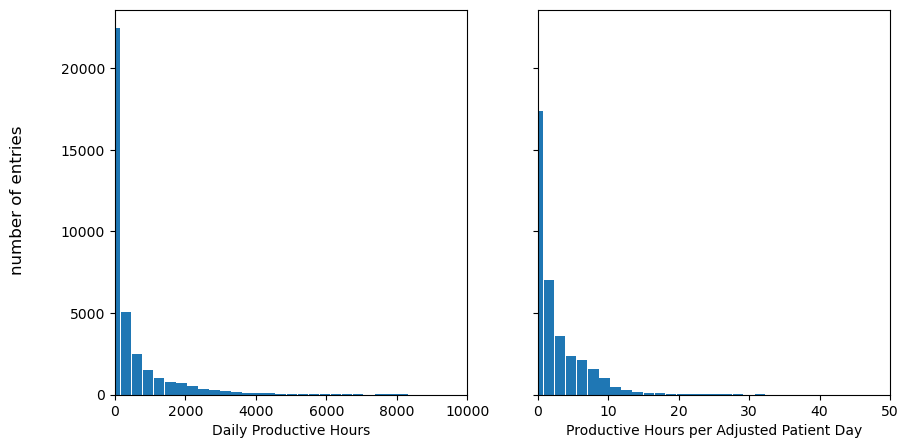

In [45]:
# Plot the distribution of values for the DPH and the PHpAPD columns
x0, y0 = cfns.bucketize(df.DPH.to_numpy(), 100)
x1, y1 = cfns.bucketize(df.PHpAPD.to_numpy(), 100)


# Plot the data for different Hours Type
fig, axs = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
axs[0].bar(x0, y0, width=300)
axs[0].set_xlim(0,10000)
axs[0].set_xlabel('Daily Productive Hours')
axs[1].bar(x1, y1, width=1.5)
axs[1].set_xlim(0,50)
axs[1].set_xlabel('Productive Hours per Adjusted Patient Day')
fig.supylabel('number of entries')
plt.show()

In [46]:
# Compute standard deviation for DPH and PHpAPD
scale_factors = {'DPH': np.sqrt(np.var(df.DPH.to_numpy())),
                 'PHpAPD': np.sqrt(np.var(df.PHpAPD.to_numpy()))}

# Rescale data
for col in scale_factors.keys():
    df[col] = df[col]/scale_factors[col]

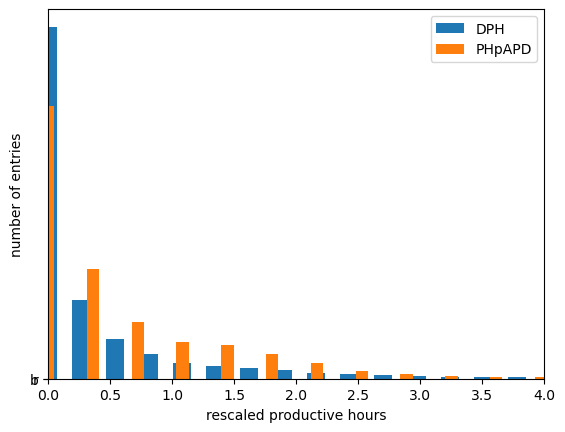

In [47]:
# Plot the distribution of rescaled values for DPH and PHpAPD columns
x1, y1 = cfns.bucketize(df.DPH.to_numpy(), 101)
x2, y2 = cfns.bucketize(df.PHpAPD.to_numpy(), 101)

plt.bar(x1, y1, 0.15, 'b', label='DPH') 
plt.bar(x2, y2, 0.1, 'r', label='PHpAPD')
plt.xlim(0,4)
plt.xlabel('rescaled productive hours')
plt.ylabel('number of entries')
plt.legend()

plt.show()

## Time series

Now that we have standardized and vectorized the data, we are ready to form our time series. We can do so by simply pivoting the dataframe.

In [48]:
df.columns

Index(['PHpAPD', 'duration', 'DPH', 'seq_len', 'y', 'fid', 'county', 'toc',
       'ht'],
      dtype='object')

In [49]:
# Set index columns and drop 'duration' and 'seq_len' columns
index_cols = ['fid','county','toc','ht']
df = df.set_index(index_cols)[['y','DPH','PHpAPD']]

# Pivot
df = df.pivot(columns='y')

df.head(1)

DPH                                            PHpAPD  \
y                         0         1         2         3         4         0   
fid county toc ht                                                               
0   0      0   0   0.151839  0.156186  0.152472  0.147115  0.147304  0.270623   

                                                           
y                         1         2         3         4  
fid county toc ht                                          
0   0      0   0   0.286814  0.321509  0.312257  0.148033

In [50]:
# Fill null values (for entries with seq_len<5) with 0.0
df = df.fillna(0.0)

In [51]:
# Drop all entries for which at least 4 out of 5 values are 0.
index_mostly_0s = df[(df.DPH==0).sum(axis=1) > 3].index
df = df.drop(index=index_mostly_0s)

print(f'{len(index_mostly_0s)} rows were dropped.')

1166 rows were dropped.


## Models

Our dataset has been cleaned, standardized and vectorized and is now almost ready to be used for machine learning. We want to build forecasting models to predict either productive hours quantity from the data of the previous years. To train such models in supervised training, we need to transform our data into input, label pairs. For instance, for an auto regressive model with two lags, AR(2), an entry sequence of length 5 should transform as follows

```
[x[0], x[1], x[2], x[3], x[4]] ---> ([x[0],x[1]] ,x[2])
                                    ([x[1],x[2]] ,x[3])
                                    ([x[2],x[3]] ,x[4])
```

### Auto-correlation function

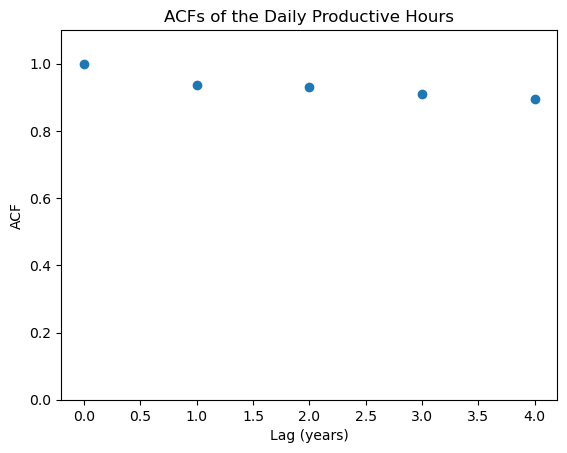

In [52]:
# Compute the acfs with lags of up to 4
lags = range(5)
dph_seqs = df.DPH.to_numpy()
dph_acfs = [cfns.seq_acf(dph_seqs, p) for p in lags]
# Plot acfs
plt.scatter(lags, dph_acfs)
plt.xlabel('Lag (years)')
plt.ylabel('ACF')
plt.ylim(0,1.1)
plt.title('ACFs of the Daily Productive Hours')
plt.show()

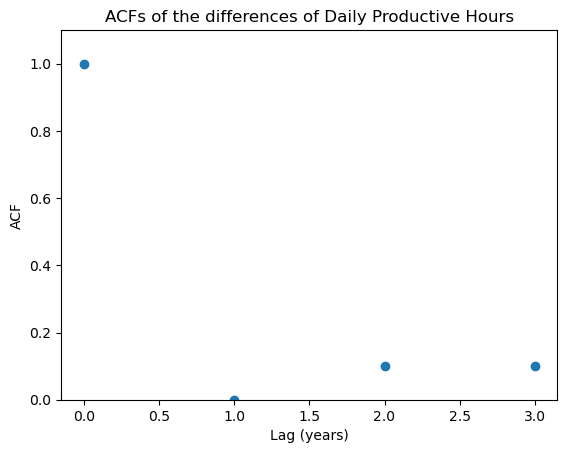

In [53]:
# Compute the acfs of the differences with lags of up to 3
lags = range(4)
dph_diff_seqs = df.DPH.diff(axis=1).to_numpy()[:,1:]
dph_diff_acfs = [np.round(cfns.seq_acf(dph_diff_seqs, p),1) for p in lags]

# Plot acfs
plt.scatter(lags, dph_diff_acfs)
plt.xlabel('Lag (years)')
plt.ylabel('ACF')
plt.ylim(0,1.1)
plt.title('ACFs of the differences of Daily Productive Hours')
plt.show()

### Train-Validation-Test split

In [54]:
# Select the DPH column and shuffle
data = df.DPH.to_numpy()
shuffle_index = shuffle(np.arange(data.shape[0]), random_state=13)
data = data[shuffle_index]

# Split as training (70%), validation (20%) and testing (10%).
l = data.shape[0]
data = {key:data[int(x[0]*l):int(x[1]*l)] for key,x in zip(
    ['train','val','test'],[[0,0.7],[0.7,0.9],[0.9,1]])}

# Print the sizes of the datasets
for key in data.keys():
    print(f'Number of sequences in the {key} dataset = {len(data[key])}')

Number of sequences in the train dataset = 4431
Number of sequences in the val dataset = 1266
Number of sequences in the test dataset = 634


In [55]:
# Choose loss, optimizer, evaluation metrics and callbacks
loss = keras.losses.mean_squared_error
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
metrics = keras.metrics.mean_absolute_error
callback = keras.callbacks.EarlyStopping(
    monitor="val_mean_absolute_error",
    patience=2,
    restore_best_weights=True)

### Auto-regressive models

#### AR(1)

In [56]:
# Prepare datasets for AR(1) model
ar1_ds = {key:cfns.seq_to_AR_ds(data[key],1) for key in data.keys()}

In [109]:
# Initialize and compile model
ar1_model = keras.Sequential([layers.Dense(1), layers.Lambda(lambda x: tf.abs(x))], name='AR1')
ar1_model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])

In [110]:
# Train model
ar1_history = ar1_model.fit(
    *ar1_ds['train'], validation_data=ar1_ds['val'], callbacks=[callback], epochs=10)

Epoch 1/10
554/554 [==============================] - 1s 914us/step - loss: 0.1426 - mean_absolute_error: 0.1122 - val_loss: 0.0337 - val_mean_absolute_error: 0.0802
Epoch 2/10
554/554 [==============================] - 0s 800us/step - loss: 0.1223 - mean_absolute_error: 0.0776 - val_loss: 0.0328 - val_mean_absolute_error: 0.0679
Epoch 3/10
554/554 [==============================] - 0s 723us/step - loss: 0.1217 - mean_absolute_error: 0.0744 - val_loss: 0.0329 - val_mean_absolute_error: 0.0690
Epoch 4/10
554/554 [==============================] - 0s 784us/step - loss: 0.1216 - mean_absolute_error: 0.0755 - val_loss: 0.0330 - val_mean_absolute_error: 0.0707


In [123]:
def seq_gen(seq, AR_model, p=1, scale_factor=1.0, max_seq_len=8):
    '''Generate the rest of a partial sequence, seq, using the
    provided (auto-regressive) keras model up to maximum sequence
    length max_seq_len.
    '''
    i = len(seq)-1
    while i <= max_seq_len-p:
        # Infer next element of the sequence
        target = AR_model.predict(seq[i-p:], verbose=0)[0]
        # Add the inferred target to sequence
        seq = np.concatenate([seq, target])
        i+=1
    return seq*scale_factor

In [148]:
# Predictions
complete_seqs_index = df[(df.DPH == 0).sum(axis=1) == 0].index
sample_seqs = df.DPH.loc[complete_seqs_index].sample(
    3, random_state=6).to_numpy()
predictions = [[seq_gen(x[:i], ar1_model)[:6] for i in range(1,6)] for x in sample_seqs]

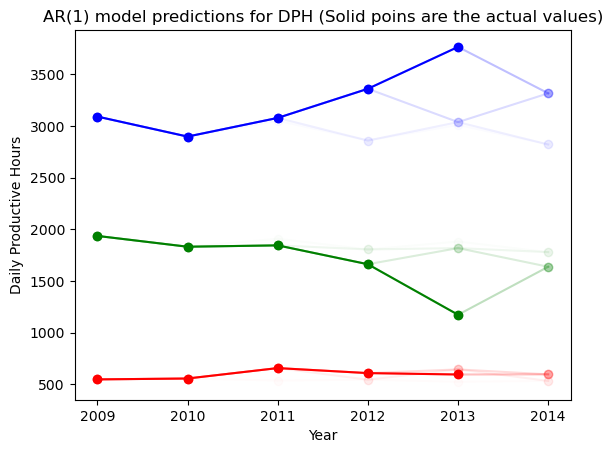

In [167]:
#plot
colors = ['b', 'g', 'r', 'c']
for i in range(3):
    plt.plot(2009+np.arange(5), scale_factors['DPH']*sample_seqs[i],
             colors[i], marker='o')
    for j in range(5):
        plt.plot(2009+np.arange(6), scale_factors['DPH']*predictions[i][j],
                 colors[i], marker='o', alpha=j**2/64)

plt.xlabel('Year')
plt.ylabel('Daily Productive Hours')
plt.title('AR(1) model predictions for DPH (Solid poins are the actual values)')
plt.show()

In [174]:
# Evaluate on the test dataset
ar1_model.evaluate(*ar1_ds['test'])

80/80 [==============================] - 0s 625us/step - loss: 0.0311 - mean_absolute_error: 0.0599


[0.031125642359256744, 0.059854406863451004]

### Simple RNN model (no features)

In [234]:
# Prepare datasets for AR(2) model
ar2_ds = {key:cfns.seq_to_AR_ds(data[key],2) for key in data.keys()}

In [235]:
# Set model parameters
r_units = 4

# Initialize the baseline model
baseline_model = keras.Sequential(
    [layers.Reshape((-1,1)),
     layers.GRU(r_units, return_sequences=False),
     layers.Dropout(0.5),
     layers.Dense(1, activation='relu')])

# Compile model
baseline_model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])

In [236]:
# Train model
baseline_history = baseline_model.fit(
    *ar2_ds['train'], validation_data=ar2_ds['val'], callbacks=[callback], epochs=20, verbose=1)

Epoch 1/20
416/416 [==============================] - 3s 4ms/step - loss: 0.9294 - mean_absolute_error: 0.3745 - val_loss: 0.3638 - val_mean_absolute_error: 0.2060
Epoch 2/20
416/416 [==============================] - 1s 3ms/step - loss: 0.5785 - mean_absolute_error: 0.2801 - val_loss: 0.2327 - val_mean_absolute_error: 0.1592
Epoch 3/20
416/416 [==============================] - 4s 10ms/step - loss: 0.5312 - mean_absolute_error: 0.2670 - val_loss: 0.1791 - val_mean_absolute_error: 0.1369
Epoch 4/20
416/416 [==============================] - 6s 13ms/step - loss: 0.4867 - mean_absolute_error: 0.2611 - val_loss: 0.1482 - val_mean_absolute_error: 0.1235
Epoch 5/20
416/416 [==============================] - 5s 11ms/step - loss: 0.4514 - mean_absolute_error: 0.2581 - val_loss: 0.1102 - val_mean_absolute_error: 0.1192
Epoch 6/20
416/416 [==============================] - 5s 12ms/step - loss: 0.4438 - mean_absolute_error: 0.2606 - val_loss: 0.0883 - val_mean_absolute_error: 0.1230
Epoch 7/20
4

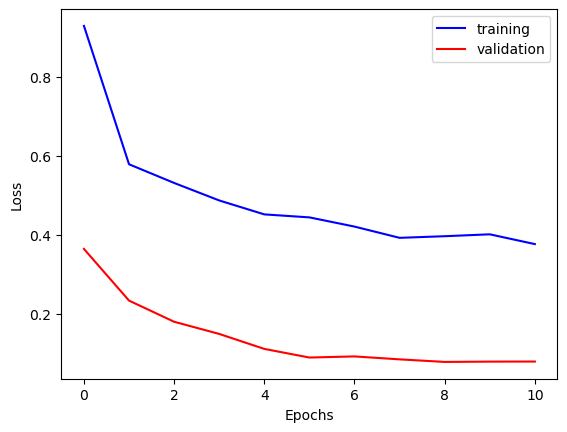

In [237]:
# Plot training history

plt.plot(np.arange(len(baseline_history.history['loss'])),
         baseline_history.history['loss'],
        'b', label='training')
plt.plot(np.arange(len(baseline_history.history['loss'])),
         baseline_history.history['val_loss'],
         'r', label='validation')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [238]:
def seq_gen(seq, rnn_model, p=3, scale_factor=1.0, max_seq_len=8):
    '''Generate the rest of a partial sequence, seq, using the
    provided (auto-regressive) keras model up to maximum sequence
    length max_seq_len.
    '''
    i = len(seq)-1
    while i <= max_seq_len-p:
        # Infer next element of the sequence
        target = rnn_model.predict(seq[np.newaxis,-p:], verbose=0)[0]
        # Add the inferred target to sequence
        seq = np.concatenate([seq, target])
        i+=1
    return seq*scale_factor

In [240]:
# Predictions
predictions = [[seq_gen(x[:i], baseline_model, p=2)[:6] for i in range(3,6)] for x in sample_seqs]

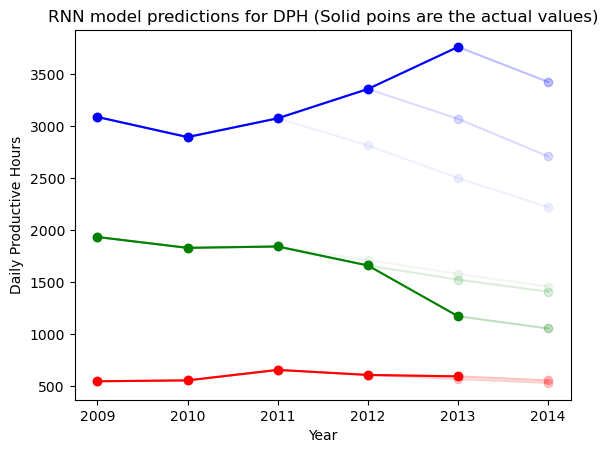

In [241]:
#plot
colors = ['b', 'g', 'r', 'c']
for i in range(3):
    plt.plot(2009+np.arange(5), scale_factors['DPH']*sample_seqs[i],
             colors[i], marker='o')
    for j in range(3):
        plt.plot(2009+np.arange(6), scale_factors['DPH']*predictions[i][j],
                 colors[i], marker='o', alpha=(j+2)**2/64)

plt.xlabel('Year')
plt.ylabel('Daily Productive Hours')
plt.title('RNN model predictions for DPH (Solid poins are the actual values)')
plt.show()

In [242]:
baseline_model.evaluate(*ar3_ds['test'])

40/40 [==============================] - 0s 3ms/step - loss: 0.0387 - mean_absolute_error: 0.0794


[0.03873689845204353, 0.07942723482847214]